In [1]:
%config Completer.use_jedi = False

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import scipy.io as sio
import mne

from scipy import signal

import pac

In [3]:
def plot_pac(pac, high_freq, low_freq):
    fig = plt.figure(figsize=(7, 15))
    ax = fig.subplots()
    im = ax.imshow(pac, origin='lower', interpolation='nearest')

    xticks_num = (low_freq[1] - low_freq[0]) / 5
    yticks_num = (high_freq[1] - high_freq[0]) / 10

    ax.xaxis.set_major_locator(mticker.MaxNLocator(5))
    ticks_loc = ax.get_xticks()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    xticks = [''] + [int(n) for n in np.linspace(low_freq[0],
                                                 low_freq[1], ticks_loc.shape[0]-2).tolist()] + ['']
    ax.set_xticklabels(xticks)

    ax.yaxis.set_major_locator(mticker.MaxNLocator(10))
    ticks_loc = ax.get_yticks()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    yticks = [''] + [int(n) for n in np.linspace(high_freq[0],
                                                 high_freq[1], ticks_loc.shape[0]-2).tolist()] + ['']
    ax.set_yticklabels(yticks)

    plt.show()


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a


def bandpass_firwin(ntaps, lowcut, highcut, fs, window='hamming'):
    nyq = 0.5 * fs
    taps = signal.firwin(ntaps, [lowcut, highcut], nyq=nyq, pass_zero=False,
                         window=window, scale=False)
    return taps

In [4]:

def create_tasks_df(df):
    tasks = []

    for _, participant in df.iterrows():
        if participant.Group == 'PD':
            sessions = [(1, 1 * (participant.sess1_Med == 'ON')),
                        (2, 1 * (participant.sess2_Med == 'ON'))]
        else:
            sessions = [(1, 2)]

        for sess, pd_drug_type in sessions:
            participant_tasks = {}
            participant_tasks['participant_id'] = participant['participant_id']
            participant_tasks['pd_drug_type'] = pd_drug_type
            participant_tasks['isMale'] = participant['sex'] == 'Male'
            participant_tasks['age'] = participant['age']
            participant_tasks['dir'] = os.path.join(DS_PATH, participant['participant_id'], f'ses-{sess:02}', 'eeg',)
            participant_tasks['file'] = f'{participant["participant_id"]}_ses-{sess:02}_eeg_{participant["participant_id"]}_ses-{sess:02}_task-Rest_eeg.mat'
            participant_tasks['file_formatter'] = f'{participant["participant_id"]}_ses-{sess:02}_task-Rest_{{}}'
            participant_tasks['path'] = os.path.join(
                participant_tasks['dir'], participant_tasks['file'])

            tasks.append(participant_tasks)

    tasks_df = pd.DataFrame(tasks)

    return tasks_df


def _test_tasks_df(tasks_df, i=0):
    task = tasks_df.iloc[i]

    assert os.path.exists(task.path)

    ds = sio.loadmat(task.path)

    ds['data'] = ds['EEG']

    nbchan = ds['data'][0, 0]['nbchan'][0, 0]  # .dtype
    Fs = ds['data'][0, 0]['srate'][0, 0]
    times = ds['data'][0, 0]['times']
    data = ds['data'][0, 0]['data']

    dtypes = [k for k in ds['data'][0, 0]['event'].dtype.names]
    events = pd.DataFrame([{n: event[n].item() if event[n].size > 0 else None for n in dtypes}
                           for event in ds['data'][0, 0]['event'][0]])

    electrodes = pd.read_csv(os.path.join(
        task['dir'], task['file_formatter'].format('electrodes.tsv')), sep='\t')

    reject = ds['data'][0, 0]['reject']

    print(events)


In [5]:

def analyse_events(events, data, Fs, task=None):
    epochs = {'S200': [], 'S201': [], 'S202': []}
    mvls = {'S200': [], 'S201': [], 'S202': []}
    mvl_2ds = {'S200': np.zeros((data.shape[0] - 4, data.shape[0] - 4, 200-32+1, 40-4+1)),
               'S201': np.zeros((data.shape[0] - 4, data.shape[0] - 4, 200-32+1, 40-4+1)),
               'S202': np.zeros((data.shape[0] - 4, data.shape[0] - 4, 200-32+1, 40-4+1))}

    for event in events.iloc:
        if event.type not in epochs.keys():
            continue

        epoch = data[:, event.latency-100:event.latency+500]
        epochs[event.type].append(epoch)

        mvl_2d = np.zeros(
            (epoch.shape[0] - 4, epoch.shape[0] - 4, 200-32+1, 40-4+1))
        mvl = np.zeros((epoch.shape[0] - 4, epoch.shape[0] - 4, ))
        tfds = []
        for ch in range(epoch.shape[0] - 4):
            # print(ch)
            tfd = pac.rid_rihaczek(epoch[ch], Fs)
            tfds.append(tfd)

        if task is not None:
            print(task.participant_id, event.bvmknum,
                  'tfd completed for all channels')

        for chx in range(epoch.shape[0] - 4):
            chy = chx
            # for chy in range(chx, epoch.shape[0] - 4):
            # print(chx, chy)

            mvl_2d[chx, chy] = pac.tfMVL_tfd2_2d(
                tfds[chx], tfds[chy], [32, 200], [4, 40])
            #pac.tfMVL_tfd_2d(tfd, [32, 200], [4, 40])
            mvl[chx, chy] = pac.tfMVL_tfd2(
                tfds[chx], tfds[chy], [32, 200], [4, 40])
            #pac.tfMVL_tfd(tfd, [32, 200], [4, 40])

        mvls[event.type].append(mvl)
        mvl_2ds[event.type] += mvl_2d

        # break

    epochs = np.array(epochs)
    mvls = np.array(mvls)

    return epochs, mvls, mvl_2ds


def analyse_task(task):
    print(task.participant_id, 'started')

    if not os.path.exists(task.path):
        return
    # return

    ds = sio.loadmat(task.path)

    ds['data'] = ds['EEG']

    nbchan = ds['data'][0, 0]['nbchan'][0, 0]  # .dtype
    Fs = ds['data'][0, 0]['srate'][0, 0]
    times = ds['data'][0, 0]['times']
    data = ds['data'][0, 0]['data']

    dtypes = [k for k in ds['data'][0, 0]['event'].dtype.names]
    events = pd.DataFrame([{n: event[n].item() if event[n].size > 0 else None for n in dtypes}
                           for event in ds['data'][0, 0]['event'][0]])

    electrodes = pd.read_csv(os.path.join(
        task['dir'], task['file_formatter'].format('electrodes.tsv')), sep='\t')

    reject = ds['data'][0, 0]['reject']

    b, a = signal.iirnotch(60, 30, Fs)
    data_notch = signal.filtfilt(b, a, data, padlen=150, axis=1)
    # b, a = butter_bandpass(1, 120, Fs, order=9)
    taps_hamming = bandpass_firwin(128, 1, 150, fs=Fs)
    # data_filt = signal.lfilter(taps_hamming, 1, data_notch)
    # data_filt = signal.lfilter(taps_hamming, 1, data_filt[:, ::-1])
    # data_filt = data_filt[:, ::-1]
    data_filt = signal.filtfilt(
        taps_hamming, 1, data_notch, padlen=150, axis=1)

    print(task.participant_id, 'goes for analyse events')

    epochs, mvls, mvl_2ds = analyse_events(events, data_filt, Fs, task)
    with open(os.path.join(task['dir'], task['file_formatter'].format('mvls.npy')), 'wb') as f:
        np.save(f, epochs)
        np.save(f, mvls)
        np.save(f, mvl_2ds)


In [11]:
if __name__ == '__main__':
    BASE_PATH = os.path.dirname(  # os.path.abspath(__file__)))
        os.path.abspath(''))
    # DS_PATH = os.path.join(BASE_PATH, 'ds')
    DS_PATH = os.path.join('/', 'Volumes', 'USB STICK', 'ds003490-download')

    df = pd.read_csv(os.path.join(DS_PATH, 'participants.tsv'), sep="\t")

    tasks_df = create_tasks_df(df)

    # __test__ = 1
    if '__test__' in locals():
        _test_tasks_df(tasks_df, 0)

#     from multiprocessing import Pool
#     with Pool(4) as p:
#         p.map(analyse_task, tasks_df.iloc[4:])

#     for task in tasks_df.iloc:
#         analyse_task(task)


In [13]:
task = tasks_df.iloc[0]

In [14]:
raw = mne.io.read_raw_eeglab(os.path.join(task['dir'], task['file_formatter'].format('eeg.set')),
                             preload=True)
raw.set_eeg_reference()

Reading /Volumes/USB STICK/ds003490-download/sub-001/ses-01/eeg/sub-001_ses-01_task-Rest_eeg.fdt
Reading 0 ... 294099  =      0.000 ...   588.198 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<ipython-input-14-1e41e2436aef>:1: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(task['dir'], task['file_formatter'].format('eeg.set')),


<RawEEGLAB | sub-001_ses-01_task-Rest_eeg.fdt, 67 x 294100 (588.2 s), ~150.4 MB, data loaded>

In [20]:
eeg_picks = mne.pick_types(raw.info, eeg=True, meg=False, eog=True)
freqs = (60, 120, 180, 240)
raw_notch = raw.copy().notch_filter(freqs=freqs, picks=eeg_picks)
raw_filtered = raw_notch.copy().filter(l_freq=1, h_freq=150)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 1651 samples (3.302 sec)



In [17]:
events, event_dict = mne.events_from_annotations(raw)#, event_desc={'S200': 'N', 'S201': 'S', 'S202': 'D'})
annot_from_events = mne.annotations_from_events(
    events=events, event_desc={v:k for k, v in event_dict.items()},
    sfreq=raw.info['sfreq'], orig_time=raw.info['meas_date']
)
raw.set_annotations(annot_from_events)

Used Annotations descriptions: ['S  1', 'S  2', 'S  3', 'S  4', 'S200', 'S201', 'S202', 'boundary']


<RawEEGLAB | sub-001_ses-01_task-Rest_eeg.fdt, 67 x 294100 (588.2 s), ~150.4 MB, data loaded>

In [21]:
epochs = mne.Epochs(raw_filtered, events, event_id=event_dict, tmin=-0.2, tmax=1, preload=True)

Not setting metadata
Not setting metadata
316 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 316 events and 601 original time points ...
1 bad epochs dropped


    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-22-697022bd73f1>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()


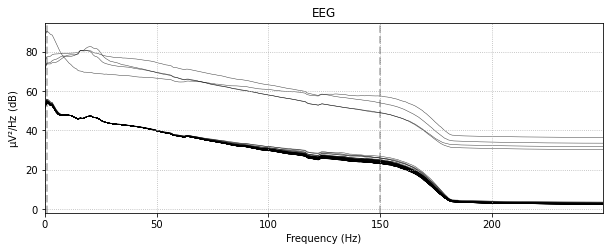

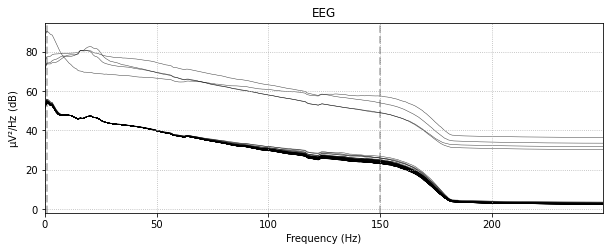

In [22]:
epochs.plot_psd()

In [78]:
epochs['S200'][0].to_data_frame()

,time,condition,epoch,Fp1,Fz,F3,F7,FT9,FC5,FC1,...,FC4,FT8,F6,F2,AF4,AF8,VEOG,X,Y,Z
0,-200,S200,126,436.035820,628.986029,623.983043,605.224192,670.134876,662.363737,658.308792,...,657.849611,667.697167,614.358530,630.021669,559.837107,448.679225,-49104.423758,2586.783281,5200.878074,505.588702
1,-198,S200,126,456.067150,647.602335,641.583695,624.471401,693.505958,679.981103,676.195345,...,678.269531,686.466973,632.924629,648.833484,579.296799,468.975649,-49505.717386,2572.876630,4252.024637,659.231718
2,-196,S200,126,503.842495,697.213880,691.780362,674.944586,747.271640,732.658253,725.608340,...,728.534830,736.163480,682.225277,699.840655,627.948979,514.728726,-50270.708859,2299.960154,2716.655921,51.839179
3,-194,S200,126,511.103663,706.490084,702.820982,685.428705,758.983543,748.929651,735.609513,...,737.089885,743.338907,691.383937,709.531821,637.247668,520.458306,-49822.186166,2365.803432,1263.462150,331.102388
4,-192,S200,126,497.885920,694.151090,690.461814,673.273289,747.733600,739.164211,723.572900,...,723.832372,730.200167,678.369609,697.177327,625.886434,509.318302,-49099.829921,2459.091127,644.922070,856.683571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,992,S200,126,558.138464,716.923914,713.357367,701.002791,742.905210,744.455229,742.284970,...,747.180816,762.010451,714.122288,725.952034,666.116488,589.404434,-42643.705258,-2898.671837,95.636720,-1133.643871
597,994,S200,126,527.487340,686.249093,680.883874,667.390014,714.329916,712.990218,711.473261,...,714.250446,723.677406,682.707589,695.209361,635.511789,558.363988,-42669.873131,-2387.883686,1102.436370,-655.546209
598,996,S200,126,506.503212,664.556773,657.961068,641.929044,694.807251,686.779588,688.679051,...,692.378617,695.234247,661.740733,673.525281,612.891184,536.285633,-42934.051934,-2027.451404,2031.241472,-247.666655
599,998,S200,126,486.045429,645.375798,638.861333,622.447980,675.907380,666.897030,668.965544,...,674.704044,676.689823,643.491324,654.669417,594.318486,515.304239,-43369.153765,-1866.558985,3502.406636,-180.242505


In [24]:
spectra, freqs = mne.psd_welch(raw, fmin=1, fmax=40, tmin=0, tmax=250,
                           n_overlap=150, n_fft=300)

AttributeError: module 'mne' has no attribute 'psd_welch'